In [1]:
import pandas as pd
import csv
import numpy as np
import scipy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import random



from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import requests
import itertools
import datetime
import io
import random
import warnings
import json
import requests
import time
import csv
import re
sns.set_palette("husl")


In [2]:
tissue_loov_df = pd.read_csv('./data_generated/gene_loov_prob.csv')
tissue_loov_df = tissue_loov_df.sort_values('Probability',ascending = False)
tissue_loov_df.head()

,Gene,Tissue,Label,Probability,Description,pct_rank
367937,ENSG00000177885,Blood,U,0.995962,GRB2,1.000000
22466,ENSG00000122435,Blood,U,0.995774,TRMT13,0.999933
125278,ENSG00000164187,Blood,U,0.995459,LMBRD2,0.999865
303367,ENSG00000020426,Blood,U,0.994897,MNAT1,0.999798
128144,ENSG00000145734,Blood,U,0.994542,BDP1,0.999731


In [3]:
loov_genes = tissue_loov_df['Description'].tolist()

In [4]:
gt_param_df = pd.read_csv('./data_generated/gt_param_df_wlabel.csv')
gt_param_df_short = gt_param_df[['Gene','Tissue','ZScore','Description']]
gt_param_df_short = gt_param_df_short[gt_param_df_short['Description'].isin(loov_genes)]
gt_param_df_short['zs_rank'] = gt_param_df_short.groupby('Tissue')['ZScore'].rank(ascending = True, pct = True)
gt_param_df_short.head()

,Gene,Tissue,ZScore,Description,zs_rank
0,ENSG00000187634,Stomach,-0.036851,SAMD11,0.848800
1,ENSG00000188976,Stomach,-0.412520,NOC2L,0.227793
2,ENSG00000187961,Stomach,-0.145059,KLHL17,0.724188
3,ENSG00000187583,Stomach,-0.314139,PLEKHN1,0.404789
4,ENSG00000187642,Stomach,-0.298348,PERM1,0.435809


In [5]:
gt_param_df_short = gt_param_df_short[['Gene','Tissue','ZScore','zs_rank']]
tissue_loov_df = pd.merge(tissue_loov_df, gt_param_df_short,  how='inner', 
                       left_on=['Gene','Tissue'], right_on = ['Gene','Tissue'])
tissue_loov_df.head()

,Gene,Tissue,Label,Probability,Description,pct_rank,ZScore,zs_rank
0,ENSG00000177885,Blood,U,0.995962,GRB2,1.000000,2.349081,0.977458
1,ENSG00000122435,Blood,U,0.995774,TRMT13,0.999933,-0.940623,0.155575
2,ENSG00000164187,Blood,U,0.995459,LMBRD2,0.999865,-1.056350,0.093130
3,ENSG00000020426,Blood,U,0.994897,MNAT1,0.999798,-1.021390,0.110221
4,ENSG00000145734,Blood,U,0.994542,BDP1,0.999731,-0.901708,0.180069


# Mice validation

In [6]:
def mice_test(mice_tis_genes,prob_df,gtex_tissue,iteration_count):
    prob_df = prob_df[prob_df['Tissue'] == gtex_tissue]
    gtex_genes = set(prob_df['Description'].tolist())
#     mice_tis_genes = list(set(mice_tis_genes) & gtex_genes)
#     print(len(gtex_genes))
#     print((mice_tis_genes))
    random_count = int(len(mice_tis_genes)*0.9)    
    mice_ranks = []
    print('Mean here')
    print(np.mean(prob_df[prob_df['Description'].isin(mice_tis_genes)]['pct_rank'].tolist()))
    print(np.mean(prob_df[prob_df['Description'].isin(mice_tis_genes)]['zs_rank'].tolist()))

    rand_ranks = []
    for i in range(iteration_count):
        mice_list = random.sample(mice_tis_genes,random_count)
        mice_rank = np.mean(prob_df[prob_df['Description'].isin(mice_list)]['pct_rank'].tolist())
        rand_rank = np.mean(prob_df[prob_df['Description'].isin(mice_list)]['zs_rank'].tolist())
        
        mice_ranks.append(mice_rank)
        rand_ranks.append(rand_rank)
        
    return mice_ranks,rand_ranks,mice_tis_genes
        


In [7]:
tissue_input_pairs = [('Heart','114'),('Breast','3463'),
                     ('Muscle','0080000'),('Lung','1579'),('Ovary','229'),
                      ('Testis','48')]

# tissue_input_pairs = [('Breast','3463')]

# ('Pancreas','26'),('Thyroid','50') <- less than 10 genes overlap

Heart
Mean here
0.6666596921445958
0.712556452332262
1.0
Breast
Mean here
0.6982746168838235
0.5429139583889828
1.9482799225479546e-18
Muscle
Mean here
0.6885385452539619
0.6918541377819521
0.9999999416078207
Lung
Mean here
0.662874781661138
0.6942094130089899
1.0
Ovary
Mean here
0.6897278915651791
0.6042661764028495
1.9482799225479546e-18
Testis
Mean here
0.6453732819002665
0.6646856379577935
1.0


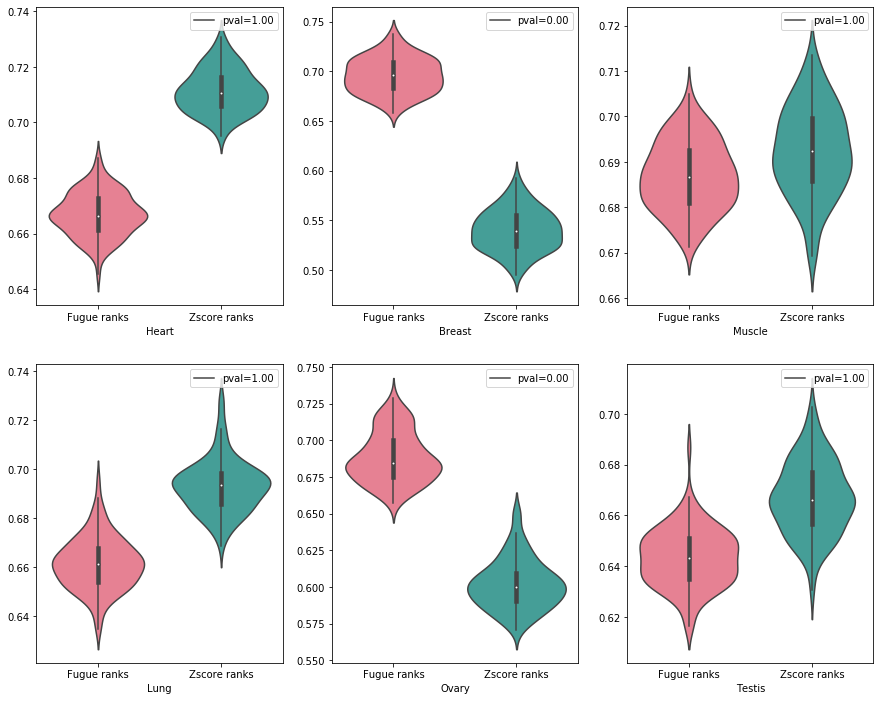

In [8]:
overlap_gene_len = []
Tissue = []
pvals = []
genes = []
mko_ranks = []
r_ranks = []
rep_tiss = []
fig = plt.figure(figsize=(15,45))

for i in range(1, 7):
    ax = fig.add_subplot(7, 3, i)
    tissue,code = tissue_input_pairs[i-1]
    print(tissue)
    Tissue.append(tissue)
    t = pd.read_excel('./data/mice_data/report.xlsx?doid=DOID:'+str(code), index_col=0)
    t  = t.replace({'\*':''}, regex=True)
    mice_genes = t['Human Homologs'].drop_duplicates().tolist()
    mice_genes = [x.strip(' ') for x in mice_genes]

    m,r,m_rel_genes = mice_test(mice_genes,tissue_loov_df,tissue,100)
    genes.append(m_rel_genes)
    overlap_gene_len.append(len(m_rel_genes))
    pval = scipy.stats.wilcoxon(m, r, zero_method='wilcox',alternative='greater')[1]
    print(pval)
    pvals.append(pval)
    ranks  = [m,r]
    rep_tiss+=list(itertools.repeat(tissue, len(m)))
    mko_ranks+=m
    r_ranks+=r
    names = ['Fugue ranks', 'Zscore ranks']
    ax = sns.violinplot(data=ranks,palette="husl")
    ax.set(xticklabels=names)
    plt.xlabel(str(tissue))
#     plt.ylabel(str(ranks))

    ax.legend(labels = ['pval={0:0.2f}'.format(pval)]) 


0.6689007162100007 0.8467704842630922
0.9900565339946557
0.8469474371531178 0.5367286973555337
0.0010907807692703848
0.7311149872534549 0.8638803166510131
0.7104014712629771
0.673486250661026 0.7432575356953992
0.9020958478636708
0.7914215848258542 0.6844887978322649
0.030937659218298965
0.6963036642495026 0.8250016043123918
0.6712712653917137


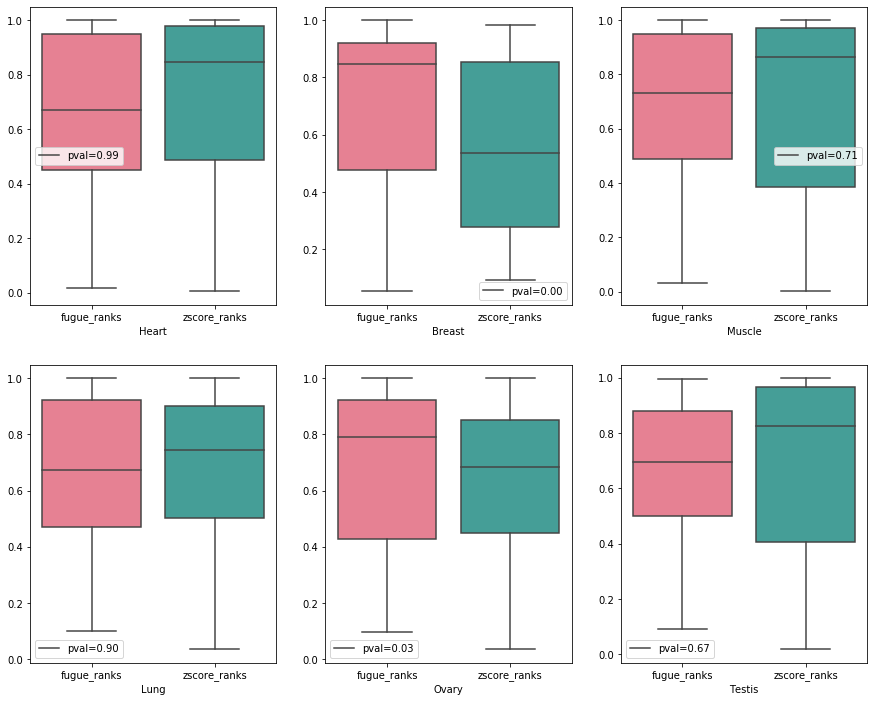

In [9]:
overlap_gene_len = []
Tissue = []
pvals = []
genes = []
mko_ranks = []
r_ranks = []
rep_tiss = []
fig = plt.figure(figsize=(15,45))

for i in range(1, 7):
    ax = fig.add_subplot(7, 3, i)
    tissue,code = tissue_input_pairs[i-1]
    Tissue.append(tissue)
    t = pd.read_excel('./data/mice_data/report.xlsx?doid=DOID:'+str(code), index_col=0)
    t  = t.replace({'\*':''}, regex=True)
    mice_genes = t['Human Homologs'].drop_duplicates().tolist()
    mice_genes = [x.strip(' ') for x in mice_genes]
    tempdf = tissue_loov_df[tissue_loov_df['Tissue']==tissue]
    fugue_ranks = tempdf[tempdf['Description'].isin(mice_genes)]['pct_rank'].tolist()
    zscore_ranks = tempdf[tempdf['Description'].isin(mice_genes)]['zs_rank'].tolist()
    print(np.median(fugue_ranks),np.median(zscore_ranks))
    pval = scipy.stats.wilcoxon(fugue_ranks, zscore_ranks, zero_method='wilcox',alternative='greater')[1]
    print(pval)
    pvals.append(pval)
    ranks  = [fugue_ranks,zscore_ranks]
    rep_tiss+=list(itertools.repeat(tissue, len(fugue_ranks)))
#     mko_ranks+=m
#     r_ranks+=r
    names = ['fugue_ranks', 'zscore_ranks']
    ax = sns.boxplot(data=ranks,palette="husl")
    ax.set(xticklabels=names)
    plt.xlabel(str(tissue))
#     plt.ylabel(str(ranks))

    ax.legend(labels = ['pval={0:0.2f}'.format(pval)]) 


Text(0.5, 0, '')

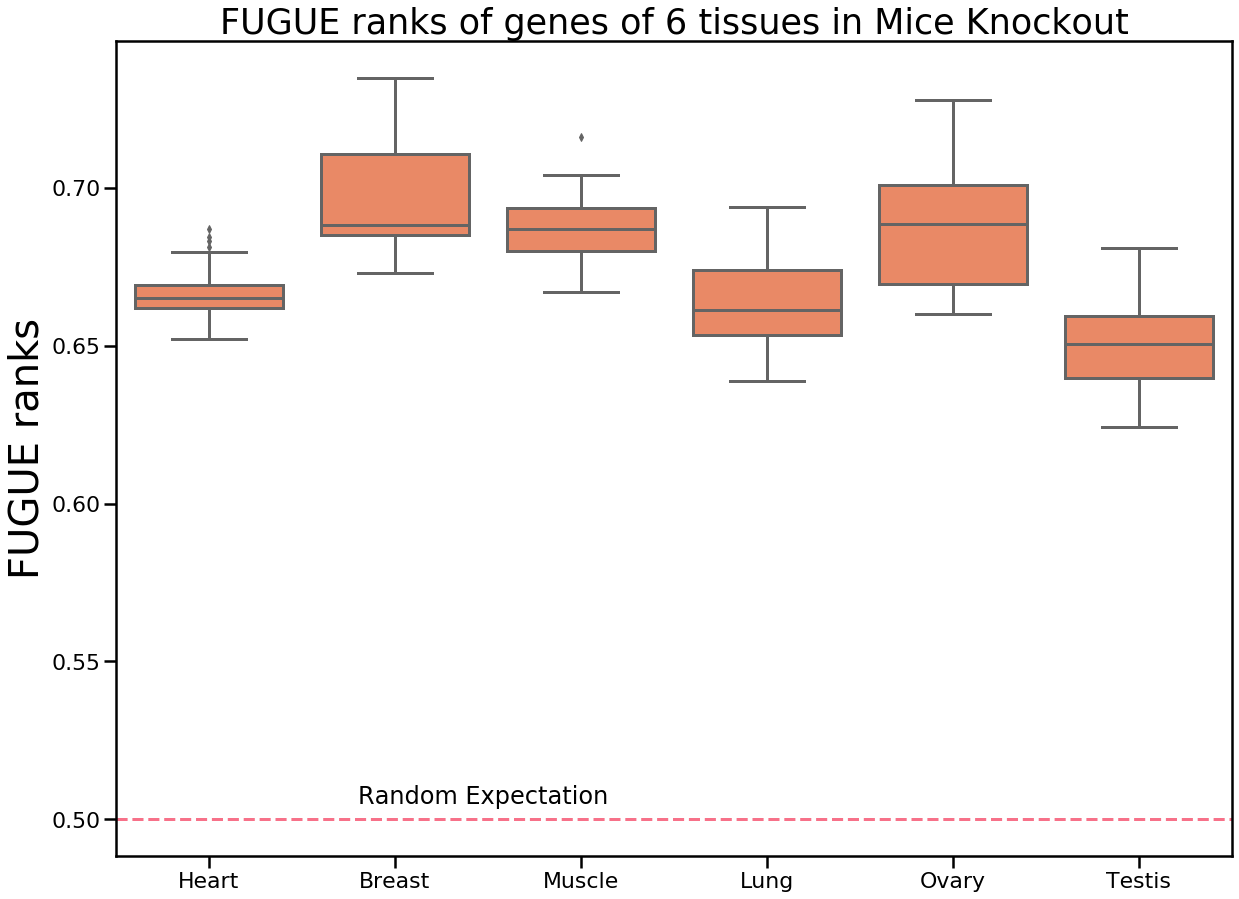

In [25]:


mko = pd.DataFrame({'Tissue':rep_tiss,'MKO_ranks':mko_ranks,'Rand_Ranks':r_ranks})
mko = pd.melt(mko, id_vars=['Tissue'], value_vars=['MKO_ranks','Rand_Ranks'])
mko.head()
mko = mko.rename(columns={'variable':'genes'})
mko = mko[mko['genes'] == 'MKO_ranks' ]


sns.set_context("poster")
fig = plt.figure(figsize=(20,15))

ax = sns.boxplot(x="Tissue", y="value",
                 data=mko, color="coral")
ax.axhline(0.5, ls='--')
ax.text(0.8,0.505, "Random Expectation")

# plt.xticks(rotation=40)
plt.title('FUGUE ranks of genes of 6 tissues in Mice Knockout',fontsize=35)

plt.ylabel('FUGUE ranks',fontsize = 40)
plt.xlabel('',fontsize = 40)

In [7]:
temp = pd.DataFrame({'Tissue':Tissue, 'numb_gene_overlap':overlap_gene_len,
             'P-value':pvals, 'Genes':genes})
temp.to_csv('./data/Mouse_KO_pvals.csv',index = False)
temp

,Tissue,numb_gene_overlap,P-value,Genes
0,Heart,179,3.778465e-10,"[LRP1, FKBP1B, TECRL, CALR, BMPR1A, PKD1, TCAP..."
1,Breast,33,1.385392e-02,"[ESPL1, RB1CC1, HMMR, BRCA1, CHEK2, RAD51, STA..."
2,Muscle,135,2.572638e-10,"[LRP1, KY, COL6A2, KLHL31, TCAP, TFAM, PYROXD1..."
3,Lung,66,8.401479e-08,"[RB1, MUC7, HMOX1, NDST1, SFTPB, FOXM1, NCF4, ..."
4,Ovary,33,2.531016e-03,"[ERRFI1, FMR1, POF1B, FGFR3, AKT2, TP53, NR5A1..."
5,Testis,54,5.600798e-09,"[MXI1, NANOS1, SYCP2, TEX14, CHEK2, MEIOB, CFA..."


In [36]:
tissue = 'Testis'
mice_genes = temp[temp['Tissue']==tissue]['Genes'].tolist()[0]

In [37]:
prob_df = gt_param_df_short[['Tissue','Description','Probability']]

gt_param_df = pd.read_csv('./data_generated/gt_param_df_wlabel.csv')
gt_param_df = gt_param_df[['Tissue','Description','ZScore','MeanExp','Breadth','CV','NeighborMeanBreadth','NeighborMeanZscore','Label']]
gt_param_df = gt_param_df[gt_param_df['Description'].isin(mice_genes)]
gt_param_df = gt_param_df[gt_param_df['Tissue']==tissue]
gt_param_df = pd.merge(gt_param_df, prob_df,  how='inner', 
                       left_on=['Description','Tissue'], right_on = ['Description','Tissue'])
print(gt_param_df.shape)
gt_param_df.to_csv('./data_generated/miceko/miceko_'+ tissue +'.csv',index = False)

gt_param_df.head()

(54, 10)


,Tissue,Description,ZScore,MeanExp,Breadth,CV,NeighborMeanBreadth,NeighborMeanZscore,Label,Probability
0,Testis,BCL10,0.232099,12.962926,0.966759,0.183530,0.773089,1.038628,U,0.719660
1,Testis,BRDT,6.327982,115.424324,1.000000,0.416313,1.000000,1.908245,U,0.298051
2,Testis,RNASEL,-0.789524,2.485485,0.027701,0.441917,0.506002,-0.098375,U,0.768486
3,Testis,EHBP1,0.463155,36.518253,0.966759,0.311939,0.951247,2.197672,U,0.456478
4,Testis,AGFG1,1.370981,38.948059,1.000000,0.247573,0.811413,1.162174,U,0.813416


In [14]:

temp['Genes'][0]

['LRP1',
 'FKBP1B',
 'TECRL',
 'CALR',
 'BMPR1A',
 'PKD1',
 'TCAP',
 'SAP130',
 'KCNJ2',
 'MYH6',
 'SMAD6',
 'RPSA',
 'FBN1',
 'PPARG',
 'BMP10',
 'TMOD1',
 'DVL2',
 'DNM1L',
 'NOS3',
 'TGFB3',
 'CACNB2',
 'SNTA1',
 'NOTCH1',
 'NPPA',
 'RBPJ',
 'JUP',
 'FGF8',
 'ZFPM2',
 'TNNI3',
 'TRPM4',
 'LMNA',
 'MYOCD',
 'KCND3',
 'KCNA5',
 'RYR2',
 'NR1D2',
 'NUP155',
 'PLN',
 'DOCK1',
 'CALM2',
 'SCN5A',
 'HCN1',
 'LRRC10',
 'DCHS1',
 'GALNT1',
 'CENPF',
 'PTPN11',
 'DOT1L',
 'PROX1',
 'TNFSF4',
 'ACTC1',
 'ACSL1',
 'NCOA6',
 'PEPD',
 'KCNK3',
 'ERBB2',
 'ABCC9',
 'DNAH11',
 'PDLIM5',
 'GNAQ',
 'ECE1',
 'PSEN2',
 'NKX2-5',
 'MYOZ2',
 'DNAH5',
 'PHC1',
 'GATA6',
 'DICER1',
 'HCN4',
 'YME1L1',
 'XIRP1',
 'BAG3',
 'EYA4',
 'PSEN1',
 'CSRP3',
 'DTNA',
 'TRDN',
 'TPM1',
 'DMD',
 'KCNQ1',
 'MAP3K7',
 'CTSV',
 'GJA1',
 'TMEM43',
 'TTN',
 'DAG1',
 'CAV3',
 'GJA5',
 'MYL3',
 'DAAM1',
 'MDM4',
 'SCN1B',
 'DES',
 'GATAD1',
 'PTGER4',
 'MYPN',
 'PDLIM3',
 'CAP2',
 'MYH7',
 'NTF3',
 'SCN3B',
 'PKP2',
 'SGCD'